### [Regression with a Mohs Hardness Dataset (S3E25)](https://www.kaggle.com/competitions/playground-series-s3e23)
Using regression to predict the Mohs hardness of a mineral, given its properties.

### Imports

In [47]:
# Basic data manipulation
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

# Model selection and evaluation tools
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import median_absolute_error

# Statistical tools
from scipy.stats import randint


### Data Import and Exploratory Data Analysis (EDA)

In [48]:
train = pd.read_csv('data/train.csv') # read train data from csv file (note that this is stored locally, in kaggle you will use the path '../input/train.csv')
train = train.drop(['id'], axis=1) # drop id column, as it is not needed for training

In [49]:
train.isna().sum() # check for missing values

allelectrons_Total       0
density_Total            0
allelectrons_Average     0
val_e_Average            0
atomicweight_Average     0
ionenergy_Average        0
el_neg_chi_Average       0
R_vdw_element_Average    0
R_cov_element_Average    0
zaratio_Average          0
density_Average          0
Hardness                 0
dtype: int64

In [50]:
train.describe() # get summary statistics for each column, useful for detecting outliers

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
count,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000
mean,128.053516,14.491342,17.033222,4.546789,37.507703,10.938308,2.607662,1.731330,0.944132,0.493349,2.132984,4.647126
std,224.123776,15.972877,10.468734,0.690864,26.012313,1.408276,0.334906,0.192481,0.180017,0.063080,1.936656,1.680525
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,68.000000,7.558488,10.000000,4.000000,20.298893,10.590660,2.530000,1.672500,0.864000,0.476196,0.814800,3.000000
50%,100.000000,10.650000,12.600000,4.714286,26.203827,11.202760,2.706000,1.732727,0.915556,0.488550,1.351550,5.500000
75%,131.000000,16.676996,22.000000,4.800000,48.719500,11.670725,2.805000,1.800000,0.981667,0.496070,2.741550,6.000000
max,15300.000000,643.093804,67.000000,6.000000,167.400000,15.245810,3.443000,2.250000,1.615840,0.825990,10.970000,10.000000


Now that we know that the training data has no severe outliers or non-numeric values, we can plot the correlation to see how variables influence each other.

<AxesSubplot:>

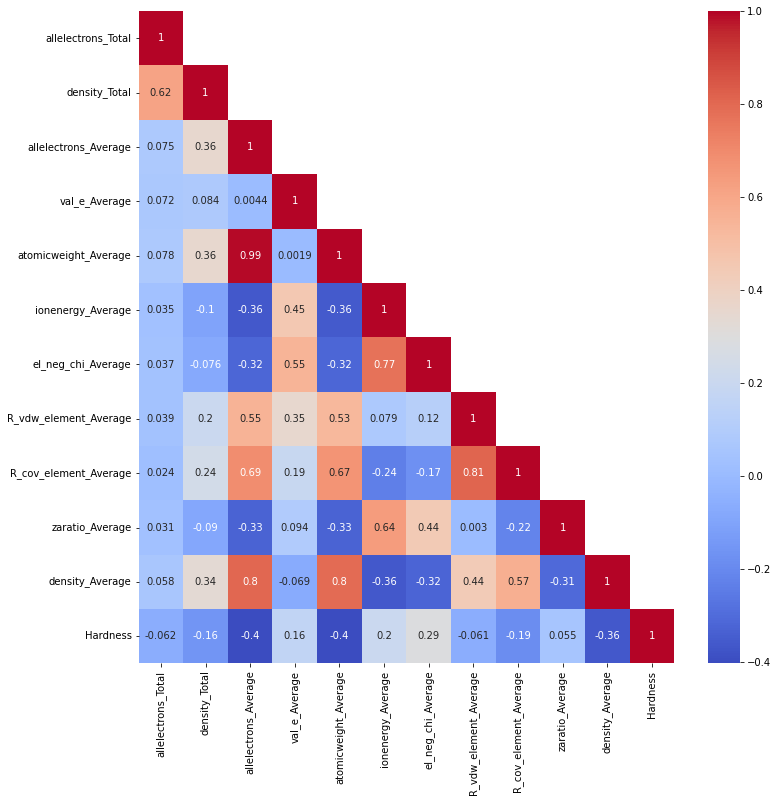

In [51]:

# Plotting correlation matrix for each column

plt.figure(figsize=(12,12)) # set figure size so annotations are not cut off
corr = train.corr() # get correlation matrix
mask = np.triu(np.ones_like(corr, dtype=bool), k=1) # create mask to hide upper triangle of plot (as it is a mirror image of the lower triangle)
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm') # plot correlation matrix with seaborn (sns)

In [52]:
#Here is a nice way of getting columns for the training data and seperating the target column

features = train.columns.to_list()[:-1] # get list of features (all columns except target)
target = train.columns.to_list().pop(-1) # get target column

#Sanity check
print(features)
print(target)

['allelectrons_Total', 'density_Total', 'allelectrons_Average', 'val_e_Average', 'atomicweight_Average', 'ionenergy_Average', 'el_neg_chi_Average', 'R_vdw_element_Average', 'R_cov_element_Average', 'zaratio_Average', 'density_Average']
Hardness


In [53]:
X = train[features] # define X as all input features
y = train[target] # define y as target column ('Hardness')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # split data into training and testing sets to evaluate model performance

### Tree-based Regressors

For this approach, I am going to use three different tree based regressors (Randomforest, XGB, and LGBM). These are briefly explained at the end of the notebook.

The regressor models are instantiated in the `regressors` dict. The respective range of hyperparameters is defined in the param_map, including a randomly generated number of estimators which scikit learn reads as `n_estimators` (randomized to reduce training time instead of iterating over every int in this range). Other hyperparams are also defined for the respective models.

In [54]:
regressors = {
    "RandomForest": RandomForestRegressor(),
    "XGB": XGBRegressor(),
    "LGBM": LGBMRegressor(),
}

param_map = {
    "RandomForest": {
        'n_estimators': randint(50, 200),
        'max_features': ['sqrt', 'log2'],
        'max_depth': randint(1, 10),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 10),
        'bootstrap': [True, False]
    },
    "XGB": {
        'n_estimators': randint(50, 200),
        'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
        'max_depth': randint(1, 10),
        'subsample': [0.5, 0.7, 1],
        'colsample_bytree': [0.5, 0.7, 1],
    },
    "LGBM": {
        'n_estimators': randint(50, 200),
        'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
        'max_depth': randint(1, 10),
        'subsample': [0.5, 0.7, 1],
        'colsample_bytree': [0.5, 0.7, 1],
    },
}


Now that we have some models, we need to train them. To do this, we implement a loop over our set of regressors. For each regressor, if it has predefined hyperparameters in `param_map`, we use RandomizedSearchCV to conduct a hyperparameter search. 

This method performs a randomized search over hyperparameters, using cross-validation with `cv_folds` folds and `n_iter_search` iterations, and aims to minimize the negative mean absolute error (MAE). 

After the search, we fit the best model found to our training data. If the regressor doesn't require hyperparameter tuning, we fit it directly to the training data. Once each model is trained, we make predictions on the test set (created using sklearn train_test_split method) and compute the MAE for performance evaluation. The results are stored, and finally, we sort and display the regressors based on their MAE, giving us a clear view of which models performed best.

In [55]:
results = {}
best_models = {}
best_params = {}

n_iter_search = 10 
cv_folds = 5        

for name, reg in regressors.items():
    if name in param_map:
        random_search = RandomizedSearchCV(reg, param_distributions=param_map[name],
                                           n_iter=n_iter_search, scoring='neg_mean_absolute_error', cv=cv_folds, 
                                           verbose=1, n_jobs=-1)
        random_search.fit(X_train, y_train)
        
        # Use the best estimator
        best_reg = random_search.best_estimator_
        best_params[name] = random_search.best_params_
    else:
        best_reg = reg
        best_reg.fit(X_train, y_train)
    
    # Predict values
    y_pred = best_reg.predict(X_test)
    
    # Compute MAE
    mae = median_absolute_error(y_test, y_pred)
    
    results[name] = mae
    best_models[name] = best_reg
    print(f"{name} MAE: {mae:.4f}")

# Sort and display results
sorted_results = dict(sorted(results.items(), key=lambda item: item[1]))
print("\nRegressors ranked by MAE:")
for name, mae in sorted_results.items():
    print(f"{name}: {mae:.4f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomForest MAE: 0.6844
Fitting 5 folds for each of 10 candidates, totalling 50 fits
XGB MAE: 0.6896
Fitting 5 folds for each of 10 candidates, totalling 50 fits
LGBM MAE: 0.6586

Regressors ranked by MAE:
LGBM: 0.6586
RandomForest: 0.6844
XGB: 0.6896


As you can see, the LGBM preformed the best. For simplicity we will go with just this model (with the respective hyperparameters saved in the best_models object).

In [56]:
test = pd.read_csv('data/test.csv')
X_submission = test[features] #create the set of features to pass to the trained model to get the predictions

In [57]:
preds = []
preds = best_models['LGBM'].predict(X_submission) #get the predictions
preds = pd.DataFrame(preds, columns=['target']) #convert the predictions to a dataframe to concatenate with the id column

In [58]:
submission = pd.concat([test['id'], preds], axis=1) #concatenate the id and predictions dataframes
submission.to_csv('submission.csv', index=False) #create the submission csv file without the index column

### Thats it!!

After running this last cell, you should have a submission file that you can upload to Kaggle! 

### *Brief description of the tree based regressors used:*


Random Forest: Random Forest is an ensemble learning method, primarily used for classification and regression. It operates by constructing a multitude of decision trees at training time and outputting the mean prediction of the individual trees. Random Forests are known for their simplicity and the fact that they can be used for both classification and regression tasks. They are robust against overfitting, especially in cases where there is a lot of noise in the dataset.

XGBoost (Extreme Gradient Boosting): XGBoost is an efficient and scalable implementation of gradient boosting framework. This algorithm has gained popularity due to its speed and performance. It uses gradient boosting framework at its core, which means it constructs new trees that predict the residuals or errors of prior trees combined together and then this process is repeated until a certain number of trees are reached, or no further improvements can be made. It is particularly well-suited for large and complex datasets and has been the algorithm behind many winning solutions in Kaggle competitions.

LightGBM (Light Gradient Boosting Machine): LightGBM is another gradient boosting framework that uses tree-based learning algorithms and is designed for distributed and efficient training. What sets LightGBM apart is its ability to handle large amounts of data and speed up the training process. It achieves this through techniques such as Gradient-based One-Side Sampling (GOSS) and Exclusive Feature Bundling (EFB). LightGBM is often preferred when dealing with extremely large datasets and scenarios where computational efficiency is a priority.